In [4]:
!pip install tensorflow keras

In [7]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


def create_model(num_classes):
    """
    Define and compile a model using transfer learning (MobileNetV2).
    """
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


def train_model(data_dir, save_dir):
    """
    Train the model using augmented data and save as TFLite.
    """
    datagen = ImageDataGenerator(
        validation_split=0.2,  # Split data into train and validation sets
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        subset="training"
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        subset="validation"
    )

    model = create_model(num_classes=len(train_generator.class_indices))
    print(f"Class mapping: {train_generator.class_indices}")

    # Define callbacks
    checkpoint_path = os.path.join(save_dir, "best_model.keras")
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True)
    ]

    model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Load the best model
    model = tf.keras.models.load_model(checkpoint_path)

    # Convert and save as TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    tflite_path = os.path.join(save_dir, "weather_classification_model.tflite")
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)

    print(f"Model saved as {checkpoint_path}")
    print(f"TFLite model saved as {tflite_path}")


def main():
    """
    Main function for training the model.
    """
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Install Kaggle CLI
    os.system("pip install kaggle")

    # Download the dataset from Kaggle
    kaggle_dataset = "jehanbhathena/weather-dataset"
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p /content/")

    # Unzip the dataset
    os.system("unzip /content/weather-dataset.zip -d /content/weather-dataset")

    data_dir = "/content/weather-dataset"
    model_dir = "/content/drive/MyDrive/weather_model"
    os.makedirs(model_dir, exist_ok=True)

    train_model(data_dir, model_dir)


if __name__ == "__main__":
    main()


Mounted at /content/drive
Found 5490 images belonging to 1 classes.
Found 1372 images belonging to 1 classes.
Class mapping: {'dataset': 0}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 140s 722ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
 92/172 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00

KeyboardInterrupt: 

including dataset structure verification, model modification for binary classification, and ensuring correct class mode for ImageDataGenerator

Enter the path to the dataset directory: /content/weather-dataset/dataset
Subdirectory: /content/weather-dataset/dataset, Number of files: 0
Class: dew, Number of images: 698
Class: rain, Number of images: 526
Class: sandstorm, Number of images: 692
Class: snow, Number of images: 621
Class: frost, Number of images: 475
Class: rainbow, Number of images: 232
Class: fogsmog, Number of images: 851
Class: rime, Number of images: 1160
Class: lightning, Number of images: 377
Class: glaze, Number of images: 639
Class: hail, Number of images: 591
Subdirectory: /content/weather-dataset/dataset/dew, Number of files: 698
Subdirectory: /content/weather-dataset/dataset/rain, Number of files: 526
Subdirectory: /content/weather-dataset/dataset/sandstorm, Number of files: 692
Subdirectory: /content/weather-dataset/dataset/snow, Number of files: 621
Subdirectory: /content/weather-dataset/dataset/frost, Number of files: 475
Subdirectory: /content/weather-dataset/dataset/rainbow, Number of files: 232
Subd

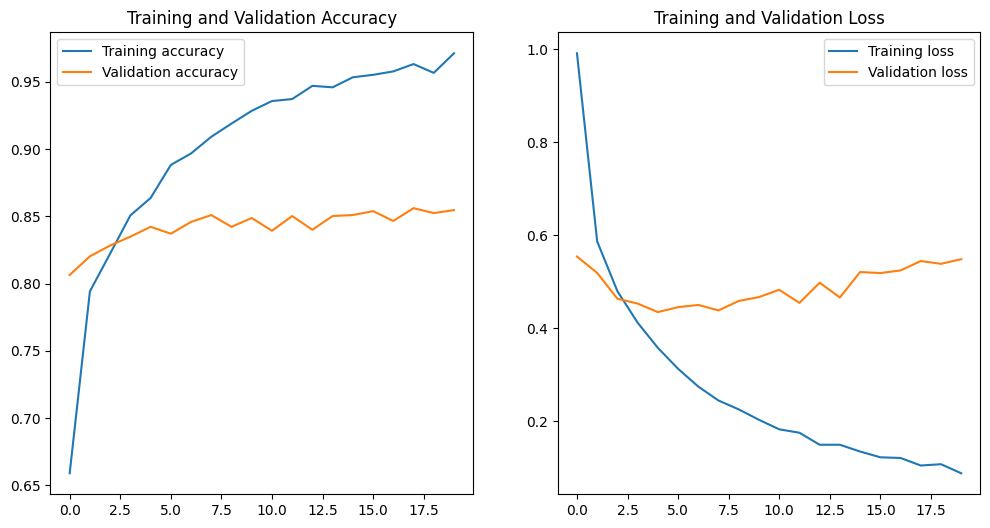

In [8]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Check directory structure
def check_dataset_structure(data_dir):
    """
    Checks the dataset directory to ensure it has subdirectories for each class.
    """
    for subdir, dirs, files in os.walk(data_dir):
        print(f"Subdirectory: {subdir}, Number of files: {len(files)}")
        for d in dirs:
            print(f"Class: {d}, Number of images: {len(os.listdir(os.path.join(subdir, d)))}")

# Load and preprocess data
def load_data(data_dir):
    """
    Loads images from the directory, processes them, and splits them into training/validation sets.
    """
    # Ensure the dataset is structured properly
    check_dataset_structure(data_dir)

    # Setup data augmentation and data generators
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize images and split into training/validation

    # Setup the training data generator
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',  # For multiple classes; use 'binary' for 2 classes
        subset='training'
    )

    # Setup the validation data generator
    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',  # For multiple classes; use 'binary' for 2 classes
        subset='validation'
    )

    return train_generator, val_generator

# Build the model
def create_model(num_classes):
    """
    Creates a CNN model using a MobileNetV2 base for transfer learning.
    """
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")  # Use sigmoid for binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Change loss for binary classification
    return model

# Train and save the model
def train_model(model, train_generator, val_generator, save_dir):
    """
    Trains the model and saves it in the specified directory.
    """
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'best_model.keras'), save_best_only=True)
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[checkpoint_cb]
    )

    # Save the final model
    model.save(os.path.join(save_dir, 'weather_classification_model.keras'))

    # Plot training history
    plot_training_history(history)

# Plot training and validation accuracy/loss
def plot_training_history(history):
    """
    Plots the training and validation accuracy/loss.
    """
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Main function to execute training pipeline
def main():
    """
    Main function to run the training pipeline.
    """
    # Define dataset directory and model save directory
    data_dir = input("Enter the path to the dataset directory: ").strip()
    save_dir = "/content/drive/MyDrive/weather_model"  # Change this path as needed
    os.makedirs(save_dir, exist_ok=True)

    # Load the data and check the dataset structure
    train_generator, val_generator = load_data(data_dir)

    # Get number of classes from the class mapping generated by flow_from_directory
    num_classes = len(train_generator.class_indices)

    print(f"Number of classes: {num_classes}")

    # Create the model
    model = create_model(num_classes)

    # Train and save the model
    train_model(model, train_generator, val_generator, save_dir)

if __name__ == "__main__":
    main()


.

code that allows the user to upload an image, apply a weather effect, and save the labeled image. The retraining section is commented out, so we can easily enable it when needed

Saving OIP.jpeg to OIP (1).jpeg


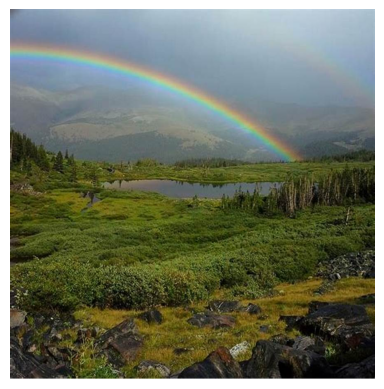

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted weather condition: rime

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. No effect (Original)
Enter the number corresponding to the effect: 1


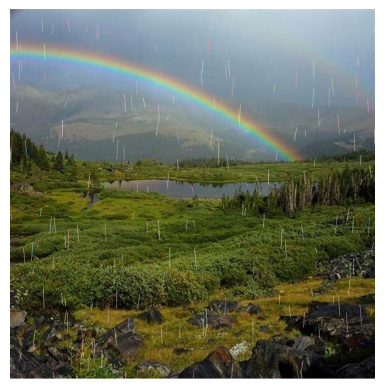

Enter the label (weather condition) for this image (e.g., 'rime', 'rain', 'snow'): rain
Image saved to /content/weather-dataset/user_uploads/rain/7615.jpg with label rain

Do you want to upload another image? (y/n): y


Saving maxresdefault.jpg to maxresdefault.jpg


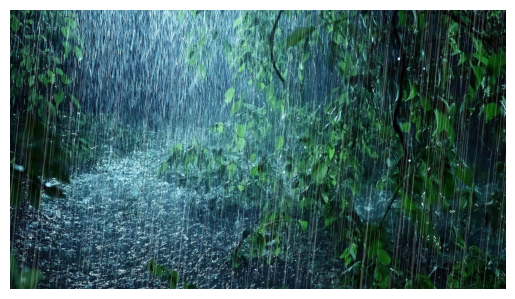

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted weather condition: dew

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. No effect (Original)
Enter the number corresponding to the effect: 3


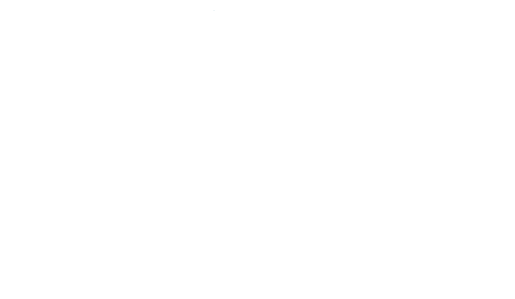

Enter the label (weather condition) for this image (e.g., 'dew', 'rain', 'snow'): No effect
Image saved to /content/weather-dataset/user_uploads/No effect/7800.jpg with label No effect

Do you want to upload another image? (y/n): y


Saving OIP.jpeg to OIP (2).jpeg


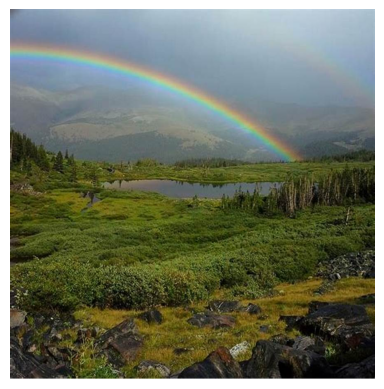

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted weather condition: rime

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. No effect (Original)
Enter the number corresponding to the effect: 2


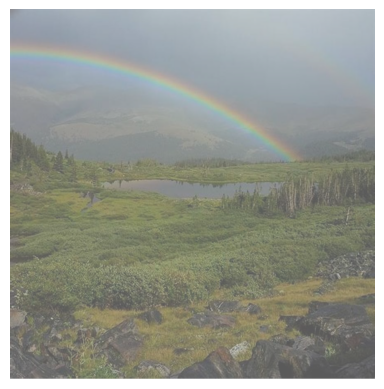

Enter the label (weather condition) for this image (e.g., 'rime', 'rain', 'snow'): fog
Image saved to /content/weather-dataset/user_uploads/fog/6559.jpg with label fog

Do you want to upload another image? (y/n): y


Saving OIP.jpeg to OIP (3).jpeg


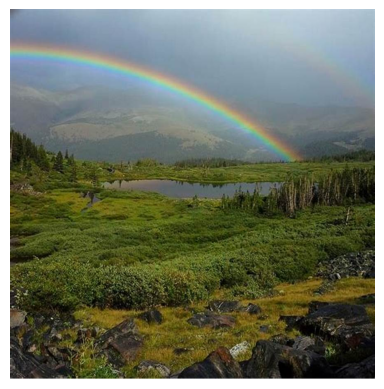

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted weather condition: rime

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. No effect (Original)
Enter the number corresponding to the effect: 3


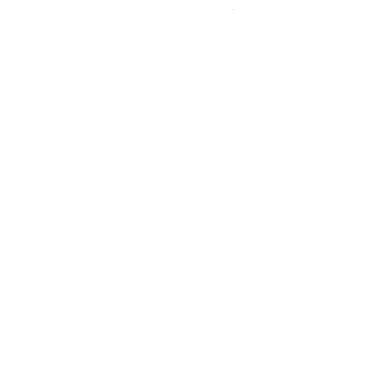

Enter the label (weather condition) for this image (e.g., 'rime', 'rain', 'snow'): No effect
Image saved to /content/weather-dataset/user_uploads/No effect/2368.jpg with label No effect

Do you want to upload another image? (y/n): n


In [10]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Directory to save user-uploaded images for future training
dataset_dir = '/content/weather-dataset/user_uploads'

# Make sure the directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Pre-trained model (e.g., MobileNetV2) for weather classification
model = load_model('/content/drive/MyDrive/weather_model/weather_classification_model.keras')  # Load your pre-trained weather classification model here

# Effect Functions
def add_rain(image, intensity=0.2):
    """Add rain effect to an image."""
    h, w, _ = image.shape
    num_lines = int(w * intensity)
    for _ in range(num_lines):
        x1 = random.randint(0, w)
        y1 = random.randint(0, h)
        x2 = x1 + random.randint(-5, 5)
        y2 = y1 + random.randint(10, 50)
        color = (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))
        cv2.line(image, (x1, y1), (x2, y2), color, 1)
    return image

def add_fog(image, intensity=0.5):
    """Add fog effect to an image."""
    fog = np.full_like(image, (180, 180, 180), dtype=np.uint8)
    return cv2.addWeighted(image, 1 - intensity, fog, intensity, 0)

def add_snow(image, intensity=0.1):
    """Add snow effect to an image."""
    h, w, _ = image.shape
    num_snowflakes = int(w * h * intensity)
    for _ in range(num_snowflakes):
        x = random.randint(0, w)
        y = random.randint(0, h)
        size = random.randint(5, 10)
        cv2.circle(image, (x, y), size, (255, 255, 255), -1)
    return image

def process_uploaded_image_and_effect():
    """Process uploaded image, apply effect, and save for training."""
    # Upload an image
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load the image
    img = cv2.imread(image_path)

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Classify the weather condition of the uploaded image
    classified_weather = classify_weather(img)
    print(f"Predicted weather condition: {classified_weather}")

    # Ask user for the weather effect to apply
    print("\nChoose the weather effect to apply:")
    print("1. Rain")
    print("2. Fog")
    print("3. Snow")
    print("4. No effect (Original)")

    effect_choice = input("Enter the number corresponding to the effect: ")

    # Apply the selected effect
    if effect_choice == '1':
        modified_image = add_rain(img)
    elif effect_choice == '2':
        modified_image = add_fog(img)
    elif effect_choice == '3':
        modified_image = add_snow(img)
    else:
        modified_image = img  # No effect

    # Display the modified image
    plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Ask the user for a label for the current image
    label = input(f"Enter the label (weather condition) for this image (e.g., '{classified_weather}', 'rain', 'snow'): ")

    # Save the image to the corresponding label folder
    label_dir = os.path.join(dataset_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Save the image
    new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
    cv2.imwrite(new_image_path, modified_image)

    print(f"Image saved to {new_image_path} with label {label}")

def classify_weather(image):
    """Classify the weather condition in the uploaded image using the pre-trained model."""
    image_resized = cv2.resize(image, (224, 224))  # Resize image to model input size
    image_array = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize the image

    # Predict weather class
    predictions = model.predict(image_array)
    class_idx = np.argmax(predictions, axis=-1)[0]

    # Assuming the model's class mapping is in the same order as the folder structure
    class_mapping = {
        0: 'dew', 1: 'rain', 2: 'sandstorm', 3: 'snow', 4: 'frost', 5: 'rainbow',
        6: 'fogsmog', 7: 'rime', 8: 'lightning', 9: 'glaze', 10: 'hail'
    }
    return class_mapping.get(class_idx, 'Unknown')

# Main function
def main():
    while True:
        process_uploaded_image_and_effect()  # Ask user for image upload and effect
        continue_choice = input("\nDo you want to upload another image? (y/n): ")
        if continue_choice.lower() != 'y':
            break

# Uncomment the following lines when you want to retrain the model with the new images
# def retrain_model(model, data_dir='/content/weather-dataset/user_uploads', epochs=5):
#     """Retrain the model with the newly uploaded images."""
#     train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#     train_data = train_datagen.flow_from_directory(
#         data_dir,
#         target_size=(256, 256),
#         batch_size=32,
#         class_mode='sparse',
#         subset='training'
#     )

#     val_data = train_datagen.flow_from_directory(
#         data_dir,
#         target_size=(256, 256),
#         batch_size=32,
#         class_mode='sparse',
#         subset='validation'
#     )

#     # Retrain the model
#     model.fit(
#         train_data,
#         epochs=epochs,
#         validation_data=val_data
#     )

#     # Save the retrained model
#     model.save('/content/weather_model_updated.h5')
#     print("Model retrained and saved.")

# Run the main function
main()


The above code is working okay for the rain but is not that great for fog and snow cases

Realism: The weather effects (rain, fog, snow) are basic but can be enhanced with more sophisticated techniques or additional libraries (like PIL for better blending).

User Experience: The interface can be improved by adding more visual feedback, like progress bars, especially for model retraining.

Performance: Ensure the pre-trained model is properly optimized for your specific use case, and consider batch processing for uploading large numbers of images.

Saving OIP.jpeg to OIP.jpeg


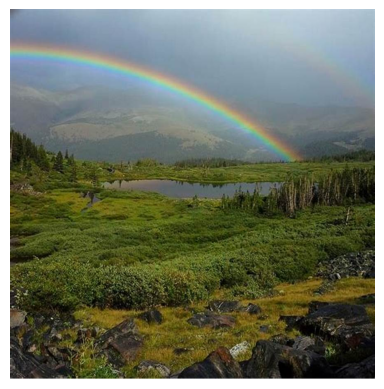

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted weather condition: rime

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 3


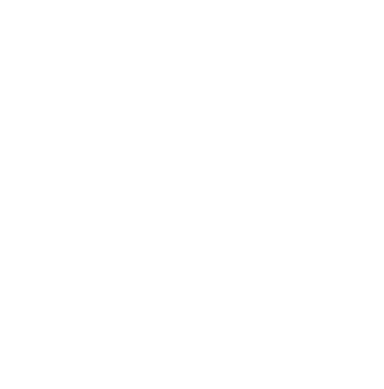

Enter the label (weather condition) for this image (e.g., 'rime', 'rain', 'snow'): snow
Image saved to /content/weather-dataset/user_uploads/snow/7324.jpg with label snow

Do you want to upload another image? (y/n): y


IndexError: list index out of range

In [9]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Directory to save user-uploaded images for future training
dataset_dir = '/content/weather-dataset/user_uploads'

# Make sure the directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Pre-trained model (e.g., MobileNetV2) for weather classification
model = load_model('/content/drive/MyDrive/weather_model/weather_classification_model.keras')  # Load your pre-trained weather classification model here

# Effect Functions
def add_rain(image, intensity=0.2):
    """Add rain effect to an image."""
    h, w, _ = image.shape
    num_lines = int(w * intensity)
    for _ in range(num_lines):
        x1 = random.randint(0, w)
        y1 = random.randint(0, h)
        x2 = x1 + random.randint(-5, 5)
        y2 = y1 + random.randint(10, 50)
        color = (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))
        cv2.line(image, (x1, y1), (x2, y2), color, 1)
    return image

def add_fog(image, intensity=0.5):
    """Add fog effect to an image."""
    fog = np.full_like(image, (180, 180, 180), dtype=np.uint8)
    return cv2.addWeighted(image, 1 - intensity, fog, intensity, 0)

def add_snow(image, intensity=0.1):
    """Add snow effect to an image."""
    h, w, _ = image.shape
    num_snowflakes = int(w * h * intensity)
    for _ in range(num_snowflakes):
        x = random.randint(0, w)
        y = random.randint(0, h)
        size = random.randint(5, 10)
        cv2.circle(image, (x, y), size, (255, 255, 255), -1)
    return image

def add_lightning(image):
    """Add a lightning strike effect to the image."""
    h, w, _ = image.shape
    x1 = random.randint(0, w)
    y1 = random.randint(0, h)
    x2 = random.randint(0, w)
    y2 = random.randint(0, h)
    color = (255, 255, 255)  # Lightning color
    thickness = random.randint(2, 4)
    cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def process_uploaded_image_and_effect():
    """Process uploaded image, apply effect, and save for training."""
    # Upload an image
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load the image
    img = cv2.imread(image_path)

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Classify the weather condition of the uploaded image
    classified_weather = classify_weather(img)
    print(f"Predicted weather condition: {classified_weather}")

    # Ask user for the weather effect to apply
    print("\nChoose the weather effect to apply:")
    print("1. Rain")
    print("2. Fog")
    print("3. Snow")
    print("4. Lightning")
    print("5. No effect (Original)")

    effect_choice = input("Enter the number corresponding to the effect: ")

    # Apply the selected effect
    if effect_choice == '1':
        modified_image = add_rain(img)
    elif effect_choice == '2':
        modified_image = add_fog(img)
    elif effect_choice == '3':
        modified_image = add_snow(img)
    elif effect_choice == '4':
        modified_image = add_lightning(img)
    else:
        modified_image = img  # No effect

    # Display the modified image
    plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Ask the user for a label for the current image
    label = input(f"Enter the label (weather condition) for this image (e.g., '{classified_weather}', 'rain', 'snow'): ")

    # Save the image to the corresponding label folder
    label_dir = os.path.join(dataset_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Save the image
    new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
    cv2.imwrite(new_image_path, modified_image)

    print(f"Image saved to {new_image_path} with label {label}")

def classify_weather(image):
    """Classify the weather condition in the uploaded image using the pre-trained model."""
    image_resized = cv2.resize(image, (224, 224))  # Resize image to model input size
    image_array = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize the image

    # Predict weather class
    predictions = model.predict(image_array)
    class_idx = np.argmax(predictions, axis=-1)[0]

    # Assuming the model's class mapping is in the same order as the folder structure
    class_mapping = {
        0: 'dew', 1: 'rain', 2: 'sandstorm', 3: 'snow', 4: 'frost', 5: 'rainbow',
        6: 'fogsmog', 7: 'rime', 8: 'lightning', 9: 'glaze', 10: 'hail'
    }
    return class_mapping.get(class_idx, 'Unknown')

# Main function
def main():
    while True:
        process_uploaded_image_and_effect()  # Ask user for image upload and effect
        continue_choice = input("\nDo you want to upload another image? (y/n): ")
        if continue_choice.lower() != 'y':
            break

# Uncomment the following lines when you want to retrain the model with the new images
# def retrain_model(model, data_dir='/content/weather-dataset/user_uploads', epochs=5):
#     """Retrain the model with the newly uploaded images."""
#     train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#     train_data = train_datagen.flow_from_directory(
#         data_dir,
#         target_size=(256, 256),
#         batch_size=32,
#         class_mode='sparse',
#         subset='training'
#     )

#     val_data = train_datagen.flow_from_directory(
#         data_dir,
#         target_size=(256, 256),
#         batch_size=32,
#         class_mode='sparse',
#         subset='validation'
#     )

#     # Retrain the model
#     model.fit(
#         train_data,
#         epochs=epochs,
#         validation_data=val_data
#     )

#     # Save the retrained model
#     model.save('/content/weather_model_updated.h5')
#     print("Model retrained and saved.")

# Run the main function
main()


further optimize and enhance the solution, we can implement the following improvements:

1. Improved Weather Effects Realism:
Rain: Instead of just lines, we can simulate falling raindrops with different opacities and velocities to create more natural-looking rain.
Fog: Implement fog as a semi-transparent layer that diffuses the image colors.
Snow: Snowflakes should vary in size and opacity, and we can simulate them falling with a slight drift.
Lightning: Create dynamic flashes that last for a short period.
2. Image Preprocessing Enhancements:
Image Augmentation: Implement a better augmentation pipeline to ensure that the model is robust to variations in lighting, zoom, and rotations.
Sharpening Effects: For certain weather conditions (like clear weather), sharpen the image to give a more realistic feel.
3. Better UI/UX Enhancements:
Weather Effect Intensity: Allow users to adjust the intensity of the applied effects (e.g., "Rain - Light, Moderate, Heavy").
Effect Preview: Allow the user to preview the effect in real-time, letting them see a sample of what their uploaded image will look like before finalizing.
4. Training Improvements:
Dynamic Data Collection: Automatically update the model's training data folder with new labeled images and offer feedback on the model's accuracy.
Model Fine-tuning with Class Weights: Fine-tune the model by adjusting class weights if some weather categories are underrepresented.
5. Performance Enhancements:
Batch Processing: Instead of processing one image at a time, allow users to upload multiple images and apply effects or train the model in batches.
GPU Utilization: Make sure training and inference operations leverage GPU (if available) for speedier processing.


Do you want to process an image or batch upload images? (single/batch): single


Saving OIP.jpeg to OIP (2).jpeg


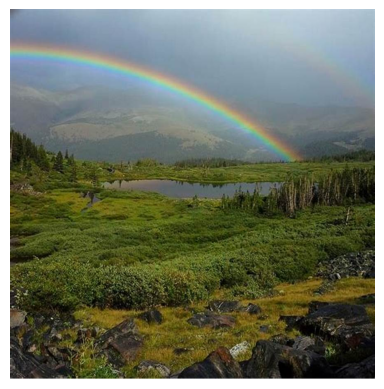


Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 1

Enter intensity value between 0 and 1 (default is 0.2): 0.005


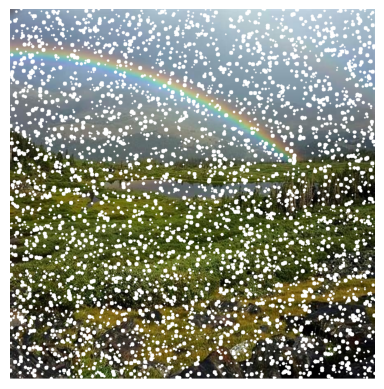

Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): snow
Image saved to /content/weather-dataset/user_uploads/snow/2837.jpg with label snow

Do you want to upload another image or batch? (y/n): y

Do you want to process an image or batch upload images? (single/batch): single


Saving OIP.jpeg to OIP (3).jpeg


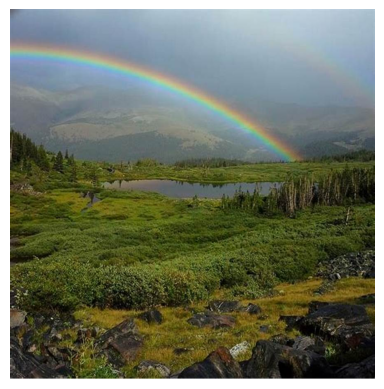


Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 3

Enter intensity value between 0 and 1 (default is 0.2): 0.0002


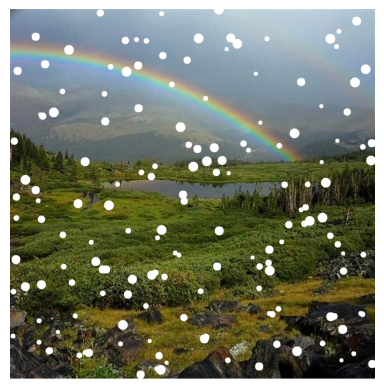

Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): snow
Image saved to /content/weather-dataset/user_uploads/snow/6127.jpg with label snow

Do you want to upload another image or batch? (y/n): y

Do you want to process an image or batch upload images? (single/batch): single


Saving GEgnka4.jpg to GEgnka4.jpg


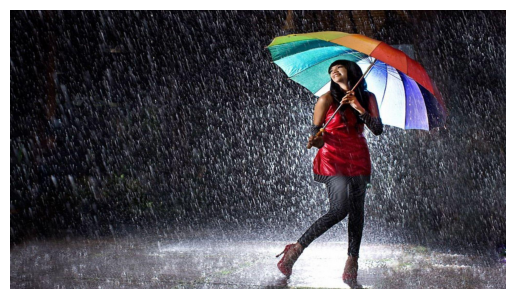


Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 4

Enter intensity value between 0 and 1 (default is 0.2): 0.005


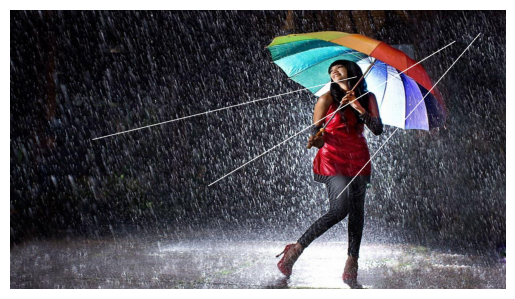

Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): lightning
Image saved to /content/weather-dataset/user_uploads/lightning/8289.jpg with label lightning

Do you want to upload another image or batch? (y/n): n


In [15]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories for saving images and training data
dataset_dir = '/content/weather-dataset/user_uploads'
train_data_dir = '/content/weather-dataset/user_uploads/train'
val_data_dir = '/content/weather-dataset/user_uploads/validation'

# Make sure the directories exist
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)

# Load pre-trained weather classification model
model = load_model('/content/drive/MyDrive/weather_model/weather_classification_model.keras')  # Pre-trained weather classification model

# Weather effect functions
def add_rain(image, intensity=0.2):
    """Simulate realistic rain effect with varying drop sizes and opacities."""
    h, w, _ = image.shape
    num_drops = int(w * h * intensity)
    for _ in range(num_drops):
        x, y = random.randint(0, w-1), random.randint(0, h-1)  # Ensure x and y are within bounds
        size = random.randint(2, 5)
        opacity = random.uniform(0.1, 0.6)

        # Apply the rain effect as circles
        cv2.circle(image, (x, y), size, (255, 255, 255), -1)

        # Adjust opacity by blending with the existing pixel color
        # Ensure we blend the pixel values properly
        image[y, x] = [(1 - opacity) * val + opacity * 255 for val in image[y, x]]
        image[y, x] = np.clip(image[y, x], 0, 255)  # Ensure values remain in the valid range

    return image

def add_fog(image, intensity=0.5):
    """Add semi-transparent fog that diffuses colors in the image."""
    fog_layer = np.full_like(image, (180, 180, 180), dtype=np.uint8)

    # Blend the fog layer with the image using the intensity factor
    image = cv2.addWeighted(image, 1 - intensity, fog_layer, intensity, 0)

    return image

def add_snow(image, intensity=0.1):
    """Add snowflakes with variation in size and opacity."""
    h, w, _ = image.shape
    num_snowflakes = int(w * h * intensity)
    for _ in range(num_snowflakes):
        x, y = random.randint(0, w-1), random.randint(0, h-1)  # Ensure x and y are within bounds
        size = random.randint(5, 12)
        opacity = random.uniform(0.2, 0.7)

        # Apply snowflakes as circles
        cv2.circle(image, (x, y), size, (255, 255, 255), -1)

        # Adjust opacity by blending with the existing pixel color
        image[y, x] = [(1 - opacity) * val + opacity * 255 for val in image[y, x]]
        image[y, x] = np.clip(image[y, x], 0, 255)  # Ensure values remain in the valid range

    return image

def add_lightning(image):
    """Add a dynamic lightning strike effect to the image."""
    h, w, _ = image.shape
    num_strikes = random.randint(1, 3)
    for _ in range(num_strikes):
        x1, y1 = random.randint(0, w), random.randint(0, h)
        x2, y2 = random.randint(0, w), random.randint(0, h)

        # Apply the lightning strike as a bright line (white color)
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return image


def process_uploaded_image_and_effect():
    """Process uploaded image, apply effect, and save for training."""
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load the image
    img = cv2.imread(image_path)

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Ask user for the weather effect to apply
    print("\nChoose the weather effect to apply:")
    print("1. Rain")
    print("2. Fog")
    print("3. Snow")
    print("4. Lightning")
    print("5. No effect (Original)")

    effect_choice = input("Enter the number corresponding to the effect: ")

    # Ask for intensity slider input for more control over the effect
    intensity = float(input("\nEnter intensity value between 0 and 1 (default is 0.2): ") or 0.2)

    # Apply the selected effect
    if effect_choice == '1':
        modified_image = add_rain(img, intensity)
    elif effect_choice == '2':
        modified_image = add_fog(img, intensity)
    elif effect_choice == '3':
        modified_image = add_snow(img, intensity)
    elif effect_choice == '4':
        modified_image = add_lightning(img)
    else:
        modified_image = img  # No effect

    # Display the modified image
    plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Ask user for a label for the current image
    label = input("Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): ")

    # Save the image to the corresponding label folder
    label_dir = os.path.join(dataset_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Save the image
    new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
    cv2.imwrite(new_image_path, modified_image)

    print(f"Image saved to {new_image_path} with label {label}")

def classify_weather(image):
    """Classify the weather condition in the uploaded image using the pre-trained model."""
    image_resized = cv2.resize(image, (224, 224))  # Resize image to model input size
    image_array = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize the image

    # Predict weather class
    predictions = model.predict(image_array)
    class_idx = np.argmax(predictions, axis=-1)[0]

    class_mapping = {
        0: 'dew', 1: 'rain', 2: 'sandstorm', 3: 'snow', 4: 'frost', 5: 'rainbow',
        6: 'fogsmog', 7: 'rime', 8: 'lightning', 9: 'glaze', 10: 'hail'
    }
    return class_mapping.get(class_idx, 'Unknown')

def batch_process_and_classify():
    """Batch process multiple uploaded images with user-selected weather effects."""
    uploaded = files.upload()
    for image_path in uploaded.keys():
        img = cv2.imread(image_path)
        print(f"Processing image: {image_path}")

        # Ask user for the weather effect to apply
        print("\nChoose the weather effect to apply:")
        print("1. Rain")
        print("2. Fog")
        print("3. Snow")
        print("4. Lightning")
        print("5. No effect (Original)")

        effect_choice = input("Enter the number corresponding to the effect: ")

        # Apply selected effect
        if effect_choice == '1':
            modified_image = add_rain(img, intensity=0.2)
        elif effect_choice == '2':
            modified_image = add_fog(img, intensity=0.3)
        elif effect_choice == '3':
            modified_image = add_snow(img, intensity=0.15)
        elif effect_choice == '4':
            modified_image = add_lightning(img)
        else:
            modified_image = img  # No effect

        # Display the modified image
        plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Ask user for the label
        label = input("Enter the label for this image (e.g., 'rain', 'snow'): ")

        # Save the image with the corresponding label
        label_dir = os.path.join(dataset_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
        cv2.imwrite(new_image_path, modified_image)
        print(f"Image saved as {new_image_path} with label {label}")

def main():
    while True:
        process_choice = input("\nDo you want to process an image or batch upload images? (single/batch): ")

        if process_choice == 'single':
            process_uploaded_image_and_effect()
        elif process_choice == 'batch':
            batch_process_and_classify()

        continue_choice = input("\nDo you want to upload another image or batch? (y/n): ")
        if continue_choice.lower() != 'y':
            break

# Run the main function
main()


.

.


Do you want to process an image or batch upload images? (single/batch): single


Saving OIP.jpeg to OIP (1).jpeg


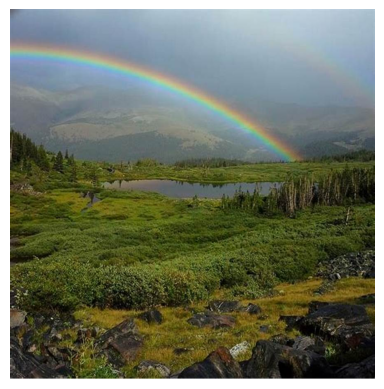


Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 1

Enter intensity value between 0 and 1 (default is 0.2): 0.0002


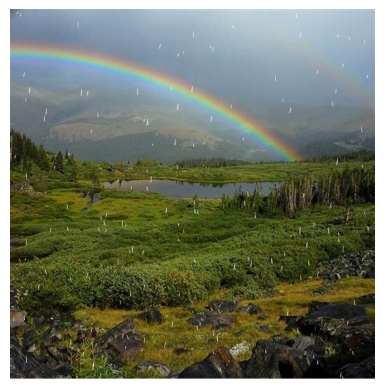


Do you want to apply another effect on this image? (y/n): y

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 1

Enter intensity value between 0 and 1 (default is 0.2): 0.002


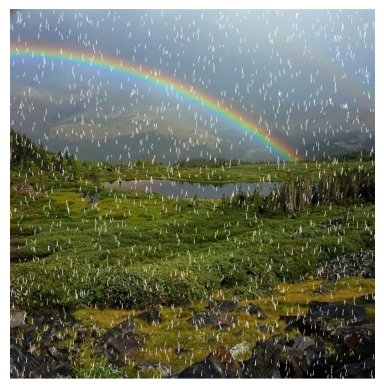


Do you want to apply another effect on this image? (y/n): n
Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): rain
Image saved to /content/weather-dataset/user_uploads/rain/3687.jpg with label rain

Do you want to upload another image or batch? (y/n): n


In [18]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories for saving images and training data
dataset_dir = '/content/weather-dataset/user_uploads'
train_data_dir = '/content/weather-dataset/user_uploads/train'
val_data_dir = '/content/weather-dataset/user_uploads/validation'

# Make sure the directories exist
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)

# Load pre-trained weather classification model
model = load_model('/content/drive/MyDrive/weather_model/weather_classification_model.keras')  # Pre-trained weather classification model

# Weather effect functions
def add_rain(image, intensity=0.2):
    """Simulate realistic rain effect with varying drop sizes and opacities."""
    h, w, _ = image.shape
    num_drops = int(w * h * intensity)

    # Simulate rain drops with lines instead of circles
    for _ in range(num_drops):
        x, y = random.randint(0, w-1), random.randint(0, h-1)  # Ensure x and y are within bounds
        length = random.randint(5, 15)  # Random length of each rain drop
        opacity = random.uniform(0.2, 0.7)  # Random opacity

        # Draw the rain drop as a line
        x2, y2 = x + random.randint(-3, 3), y + length  # Random direction to simulate falling
        cv2.line(image, (x, y), (x2, y2), (255, 255, 255), 1)

        # Adjust opacity by blending with the existing pixel color
        # We blend each pixel based on opacity
        for i in range(length):
            if y + i < h:  # Make sure we are within image bounds
                image[y + i, x] = [(1 - opacity) * val + opacity * 255 for val in image[y + i, x]]
                image[y + i, x] = np.clip(image[y + i, x], 0, 255)  # Ensure values remain within valid range

    return image


def add_fog(image, intensity=0.5):
    """Add semi-transparent fog that diffuses colors in the image."""
    fog_layer = np.full_like(image, (180, 180, 180), dtype=np.uint8)

    # Blend the fog layer with the image using the intensity factor
    image = cv2.addWeighted(image, 1 - intensity, fog_layer, intensity, 0)

    return image

def add_snow(image, intensity=0.1):
    """Add snowflakes with variation in size and opacity."""
    h, w, _ = image.shape
    num_snowflakes = int(w * h * intensity)
    for _ in range(num_snowflakes):
        x, y = random.randint(0, w-1), random.randint(0, h-1)  # Ensure x and y are within bounds
        size = random.randint(5, 12)
        opacity = random.uniform(0.2, 0.7)

        # Apply snowflakes as circles
        cv2.circle(image, (x, y), size, (255, 255, 255), -1)

        # Adjust opacity by blending with the existing pixel color
        image[y, x] = [(1 - opacity) * val + opacity * 255 for val in image[y, x]]
        image[y, x] = np.clip(image[y, x], 0, 255)  # Ensure values remain in the valid range

    return image

def add_lightning(image):
    """Add a dynamic lightning strike effect to the image."""
    h, w, _ = image.shape
    num_strikes = random.randint(1, 3)
    for _ in range(num_strikes):
        x1, y1 = random.randint(0, w), random.randint(0, h)
        x2, y2 = random.randint(0, w), random.randint(0, h)

        # Apply the lightning strike as a bright line (white color)
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return image


def process_uploaded_image_and_effect():
    """Process uploaded image, apply effect, and save for training."""
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load the image
    img = cv2.imread(image_path)

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    modified_image = img  # Start with the original image

    while True:
        # Ask user for the weather effect to apply
        print("\nChoose the weather effect to apply:")
        print("1. Rain")
        print("2. Fog")
        print("3. Snow")
        print("4. Lightning")
        print("5. No effect (Original)")

        effect_choice = input("Enter the number corresponding to the effect: ")

        # Ask for intensity slider input for more control over the effect
        intensity = float(input("\nEnter intensity value between 0 and 1 (default is 0.2): ") or 0.2)

        # Apply the selected effect
        if effect_choice == '1':
            modified_image = add_rain(modified_image, intensity)
        elif effect_choice == '2':
            modified_image = add_fog(modified_image, intensity)
        elif effect_choice == '3':
            modified_image = add_snow(modified_image, intensity)
        elif effect_choice == '4':
            modified_image = add_lightning(modified_image)
        else:
            modified_image = img  # No effect

        # Display the modified image
        plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Ask the user if they want to apply another effect to the image
        continue_effect = input("\nDo you want to apply another effect on this image? (y/n): ")
        if continue_effect.lower() != 'y':
            break

    # Ask user for a label for the current image
    label = input("Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): ")

    # Save the image to the corresponding label folder
    label_dir = os.path.join(dataset_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Save the image
    new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
    cv2.imwrite(new_image_path, modified_image)

    print(f"Image saved to {new_image_path} with label {label}")

def classify_weather(image):
    """Classify the weather condition in the uploaded image using the pre-trained model."""
    image_resized = cv2.resize(image, (224, 224))  # Resize image to model input size
    image_array = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize the image

    # Predict weather class
    predictions = model.predict(image_array)
    class_idx = np.argmax(predictions, axis=-1)[0]

    class_mapping = {
        0: 'dew', 1: 'rain', 2: 'sandstorm', 3: 'snow', 4: 'frost', 5: 'rainbow',
        6: 'fogsmog', 7: 'rime', 8: 'lightning', 9: 'glaze', 10: 'hail'
    }
    return class_mapping.get(class_idx, 'Unknown')

def batch_process_and_classify():
    """Batch process multiple uploaded images with user-selected weather effects."""
    uploaded = files.upload()
    for image_path in uploaded.keys():
        img = cv2.imread(image_path)
        print(f"Processing image: {image_path}")

        # Ask user for the weather effect to apply
        print("\nChoose the weather effect to apply:")
        print("1. Rain")
        print("2. Fog")
        print("3. Snow")
        print("4. Lightning")
        print("5. No effect (Original)")

        effect_choice = input("Enter the number corresponding to the effect: ")

        # Apply selected effect
        if effect_choice == '1':
            modified_image = add_rain(img, intensity=0.2)
        elif effect_choice == '2':
            modified_image = add_fog(img, intensity=0.3)
        elif effect_choice == '3':
            modified_image = add_snow(img, intensity=0.15)
        elif effect_choice == '4':
            modified_image = add_lightning(img)
        else:
            modified_image = img  # No effect

        # Display the modified image
        plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Ask user for the label
        label = input("Enter the label for this image (e.g., 'rain', 'snow'): ")

        # Save the image with the corresponding label
        label_dir = os.path.join(dataset_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
        cv2.imwrite(new_image_path, modified_image)
        print(f"Image saved as {new_image_path} with label {label}")

def main():
    while True:
        process_choice = input("\nDo you want to process an image or batch upload images? (single/batch): ")

        if process_choice == 'single':
            process_uploaded_image_and_effect()
        elif process_choice == 'batch':
            batch_process_and_classify()

        continue_choice = input("\nDo you want to upload another image or batch? (y/n): ")
        if continue_choice.lower() != 'y':
            break

# Run the main function
main()


updated code to save generated image


Do you want to process an image or batch upload images? (single/batch): single


Saving cityscape.jpeg to cityscape.jpeg


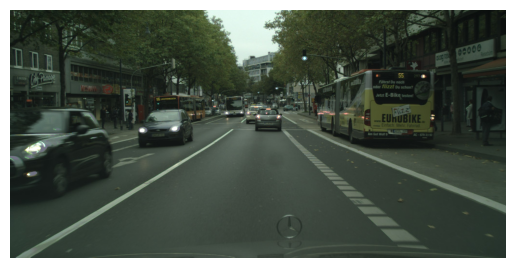


Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 1

Enter intensity value between 0 and 1 (default is 0.2): 0.002


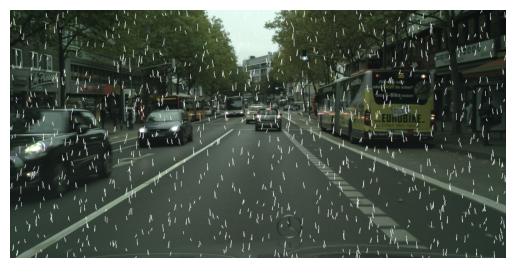


Do you want to apply another effect on this image? (y/n): y

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 1

Enter intensity value between 0 and 1 (default is 0.2): 0.003


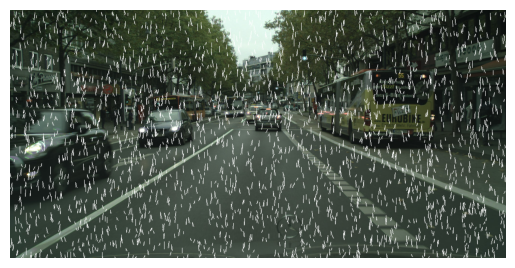


Do you want to apply another effect on this image? (y/n): y

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 3

Enter intensity value between 0 and 1 (default is 0.2): 0.003


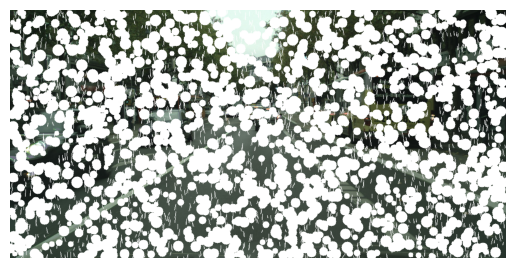


Do you want to apply another effect on this image? (y/n): n
Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): rainsnow
Image saved to /content/weather-dataset/user_uploads/rainsnow/5590.jpg with label rainsnow
Do you want to save the image at double the resolution? (y/n): y
Image saved to /content/weather-dataset/user_uploads/rainsnow/8328_doubled.jpg with label rainsnow at double the resolution

Do you want to upload another image or batch? (y/n): y

Do you want to process an image or batch upload images? (single/batch): single


Saving cityscape.jpeg to cityscape (1).jpeg


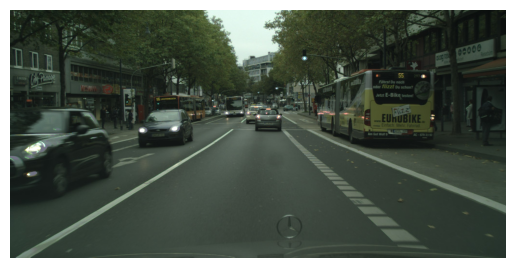


Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 0.003

Enter intensity value between 0 and 1 (default is 0.2): 0.003


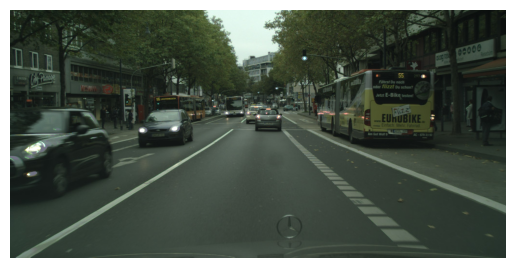


Do you want to apply another effect on this image? (y/n): y

Choose the weather effect to apply:
1. Rain
2. Fog
3. Snow
4. Lightning
5. No effect (Original)
Enter the number corresponding to the effect: 1

Enter intensity value between 0 and 1 (default is 0.2): 0.003


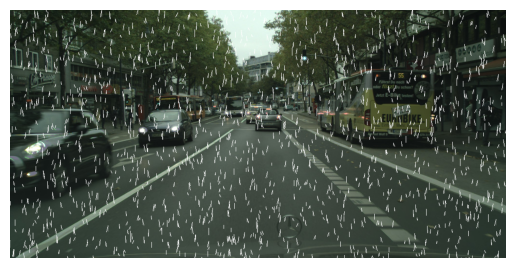


Do you want to apply another effect on this image? (y/n): n
Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): rain
Image saved to /content/weather-dataset/user_uploads/rain/3771.jpg with label rain
Do you want to save the image at double the resolution? (y/n): y
Image saved to /content/weather-dataset/user_uploads/rain/1555_doubled.jpg with label rain at double the resolution

Do you want to upload another image or batch? (y/n): n


In [19]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories for saving images and training data
dataset_dir = '/content/weather-dataset/user_uploads'
train_data_dir = '/content/weather-dataset/user_uploads/train'
val_data_dir = '/content/weather-dataset/user_uploads/validation'

# Make sure the directories exist
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)

# Load pre-trained weather classification model
model = load_model('/content/drive/MyDrive/weather_model/weather_classification_model.keras')  # Pre-trained weather classification model

# Weather effect functions
def add_rain(image, intensity=0.2):
    """Simulate realistic rain effect with varying drop sizes and opacities."""
    h, w, _ = image.shape
    num_drops = int(w * h * intensity)

    # Simulate rain drops with lines instead of circles
    for _ in range(num_drops):
        x, y = random.randint(0, w-1), random.randint(0, h-1)  # Ensure x and y are within bounds
        length = random.randint(5, 15)  # Random length of each rain drop
        opacity = random.uniform(0.2, 0.7)  # Random opacity

        # Draw the rain drop as a line
        x2, y2 = x + random.randint(-3, 3), y + length  # Random direction to simulate falling
        cv2.line(image, (x, y), (x2, y2), (255, 255, 255), 1)

        # Adjust opacity by blending with the existing pixel color
        # We blend each pixel based on opacity
        for i in range(length):
            if y + i < h:  # Make sure we are within image bounds
                image[y + i, x] = [(1 - opacity) * val + opacity * 255 for val in image[y + i, x]]
                image[y + i, x] = np.clip(image[y + i, x], 0, 255)  # Ensure values remain within valid range

    return image


def add_fog(image, intensity=0.5):
    """Add semi-transparent fog that diffuses colors in the image."""
    fog_layer = np.full_like(image, (180, 180, 180), dtype=np.uint8)

    # Blend the fog layer with the image using the intensity factor
    image = cv2.addWeighted(image, 1 - intensity, fog_layer, intensity, 0)

    return image

def add_snow(image, intensity=0.1):
    """Add snowflakes with variation in size and opacity."""
    h, w, _ = image.shape
    num_snowflakes = int(w * h * intensity)
    for _ in range(num_snowflakes):
        x, y = random.randint(0, w-1), random.randint(0, h-1)  # Ensure x and y are within bounds
        size = random.randint(5, 12)
        opacity = random.uniform(0.2, 0.7)

        # Apply snowflakes as circles
        cv2.circle(image, (x, y), size, (255, 255, 255), -1)

        # Adjust opacity by blending with the existing pixel color
        image[y, x] = [(1 - opacity) * val + opacity * 255 for val in image[y, x]]
        image[y, x] = np.clip(image[y, x], 0, 255)  # Ensure values remain in the valid range

    return image

def add_lightning(image):
    """Add a dynamic lightning strike effect to the image."""
    h, w, _ = image.shape
    num_strikes = random.randint(1, 3)
    for _ in range(num_strikes):
        x1, y1 = random.randint(0, w), random.randint(0, h)
        x2, y2 = random.randint(0, w), random.randint(0, h)

        # Apply the lightning strike as a bright line (white color)
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return image


def save_image_with_double_resolution(image, label):
    """Save the image at double the resolution of the original image."""
    h, w, _ = image.shape
    # Resize image to double the resolution
    doubled_image = cv2.resize(image, (w * 2, h * 2))

    # Create the label directory if it doesn't exist
    label_dir = os.path.join(dataset_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Save the doubled resolution image
    new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}_doubled.jpg")
    cv2.imwrite(new_image_path, doubled_image)

    print(f"Image saved to {new_image_path} with label {label} at double the resolution")

def process_uploaded_image_and_effect():
    """Process uploaded image, apply effect, and save for training."""
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load the image
    img = cv2.imread(image_path)

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    modified_image = img  # Start with the original image

    while True:
        # Ask user for the weather effect to apply
        print("\nChoose the weather effect to apply:")
        print("1. Rain")
        print("2. Fog")
        print("3. Snow")
        print("4. Lightning")
        print("5. No effect (Original)")

        effect_choice = input("Enter the number corresponding to the effect: ")

        # Ask for intensity slider input for more control over the effect
        intensity = float(input("\nEnter intensity value between 0 and 1 (default is 0.2): ") or 0.2)

        # Apply the selected effect
        if effect_choice == '1':
            modified_image = add_rain(modified_image, intensity)
        elif effect_choice == '2':
            modified_image = add_fog(modified_image, intensity)
        elif effect_choice == '3':
            modified_image = add_snow(modified_image, intensity)
        elif effect_choice == '4':
            modified_image = add_lightning(modified_image)
        else:
            modified_image = img  # No effect

        # Display the modified image
        plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Ask the user if they want to apply another effect to the image
        continue_effect = input("\nDo you want to apply another effect on this image? (y/n): ")
        if continue_effect.lower() != 'y':
            break

    # Ask user for a label for the current image
    label = input("Enter the label (weather condition) for this image (e.g., 'rain', 'snow'): ")

    # Save the image to the corresponding label folder
    label_dir = os.path.join(dataset_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Save the image
    new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
    cv2.imwrite(new_image_path, modified_image)

    print(f"Image saved to {new_image_path} with label {label}")

    # Ask if the user wants to save the image at double the resolution
    save_double = input("Do you want to save the image at double the resolution? (y/n): ")
    if save_double.lower() == 'y':
        save_image_with_double_resolution(modified_image, label)

def batch_process_and_classify():
    """Batch process multiple uploaded images with user-selected weather effects."""
    uploaded = files.upload()
    for image_path in uploaded.keys():
        img = cv2.imread(image_path)
        print(f"Processing image: {image_path}")

        # Ask user for the weather effect to apply
        print("\nChoose the weather effect to apply:")
        print("1. Rain")
        print("2. Fog")
        print("3. Snow")
        print("4. Lightning")
        print("5. No effect (Original)")

        effect_choice = input("Enter the number corresponding to the effect: ")

        # Apply selected effect
        if effect_choice == '1':
            modified_image = add_rain(img, intensity=0.2)
        elif effect_choice == '2':
            modified_image = add_fog(img, intensity=0.3)
        elif effect_choice == '3':
            modified_image = add_snow(img, intensity=0.15)
        elif effect_choice == '4':
            modified_image = add_lightning(img)
        else:
            modified_image = img  # No effect

        # Display the modified image
        plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Ask user for the label
        label = input("Enter the label for this image (e.g., 'rain', 'snow'): ")

        # Save the image with the corresponding label
        label_dir = os.path.join(dataset_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        new_image_path = os.path.join(label_dir, f"{random.randint(1000, 9999)}.jpg")
        cv2.imwrite(new_image_path, modified_image)
        print(f"Image saved as {new_image_path} with label {label}")

        # Ask if the user wants to save the image at double the resolution
        save_double = input("Do you want to save the image at double the resolution? (y/n): ")
        if save_double.lower() == 'y':
            save_image_with_double_resolution(modified_image, label)

def main():
    while True:
        process_choice = input("\nDo you want to process an image or batch upload images? (single/batch): ")

        if process_choice == 'single':
            process_uploaded_image_and_effect()
        elif process_choice == 'batch':
            batch_process_and_classify()

        continue_choice = input("\nDo you want to upload another image or batch? (y/n): ")
        if continue_choice.lower() != 'y':
            break

# Run the main function
main()
